# Time-dependent boundary conditions

initial-boundary value problem on $(\textbf{x}, t)\in\Omega\times[0,\infty)$

$$\frac{\partial u}{\partial t} = \nabla^2u + 1 - u$$

Dirichlet boundary condition on $\textbf{x}\in\partial\Omega$

$$u = u_{\text{D}}(t)$$

Neumann boundary condition on $\textbf{x}\in\partial\Omega_{\text{N}}=\partial\Omega/\partial\Omega_{\text{D}}$

$$\textbf{n}\cdot\nabla{u} = u_{\text{N}}(t)$$

time discretization

$$\frac{u^{n+1} - u^n}{\Delta t^n} = \nabla^2(\mathcal{D}_d(u)) + 1 - \mathcal{D}_r(u)$$
 
variational formulation $\forall v\in V$

$$F(u^{n+1}, v)=\int_\Omega\text{d}x~v\frac{u^{n+1} - u^n}{\Delta t^n} +\nabla v\cdot\nabla(\mathcal{D}_d(u)) -v(1-\mathcal{D}_r(u)) - \int_{\partial\Omega_{\text{N}}}\text{d}\Gamma~vu_{\text{N}}=0$$

In [ ]:
import numpy as np

from lucifex.mesh import interval_mesh
from lucifex.fdm import (
    BE, finite_difference_order,
    FiniteDifference, FunctionSeries, ConstantSeries,
)
from lucifex.sim import run, Simulation
from lucifex.fem import Constant
from lucifex.solver import ibvp, evaluation, BoundaryConditions
from lucifex.io import write
from lucifex.viz import plot_line, create_animation
from lucifex.pde.foundations import diffusion_reaction


# def diffusion_reaction(
#     u: FunctionSeries,
#     dt: Constant | float,
#     D_diff: FiniteDifference,
#     D_reac: FiniteDifference,
#     bcs: BoundaryConditions | None = None,
# ) -> list[Form]:
#     v = TestFunction(u.function_space)
#     Ft = v * DT(u, dt) * dx
#     Fd = inner(grad(v), grad(D_diff(u))) * dx
#     Fr = -v * (1 - D_reac(u)) * dx
#     forms = [Ft, Fd, Fr]
#     if bcs is not None:
#         ds, u_neumann = bcs.boundary_data(u.function_space, 'neumann')
#         F_neumann = sum([-v * uN * ds(i) for i, uN in u_neumann])
#         forms.append(F_neumann)
#     return forms

## Time-dependent Dirichlet boundary condition

$$\Omega = [0, L_x]$$

$$u_{\text{D}}(x=0, t)=\epsilon\sin(\omega t)$$

$$u_{\text{D}}(x=L_x)=0$$

In [ ]:
def sine_wave(t, eps, omega):
    return eps * np.sin(omega * float(t))


def time_dependent_bcs_simulation(
    Lx: float,
    Nx: int,
    dt: float,
    eps: float,
    omega: float,
    bc_type: str,
    D_diff: FiniteDifference,
    D_reac: FiniteDifference,
) -> Simulation:
    order = finite_difference_order(D_diff.order, D_reac.order)
    store = 1
    mesh = interval_mesh(Lx, Nx)

    t = ConstantSeries(mesh, name='t', ics=0.0)
    dt = Constant(mesh, dt, name='dt')  

    uB = ConstantSeries(mesh, order=order, store=store, ics=sine_wave(0.0, eps, omega))
    if bc_type == 'dirichlet':
        uB.name = 'uD'
        bcs = BoundaryConditions(
            ('dirichlet', lambda x: x[0], uB[1]),
            ('dirichlet', lambda x: x[0] - Lx, 0.0),
        )
    elif bc_type == 'neumann':
        uB.name = 'uN'
        bcs = BoundaryConditions(
            ('neumann', lambda x: x[0], -uB[1]),
            ('dirichlet', lambda x: x[0] - Lx, 0.0),
        )
    else:
        raise ValueError

    uB_solver = evaluation(
        uB, 
        sine_wave, 
        future=True,
    )(t[0] + dt, eps, omega)

    u = FunctionSeries((mesh, 'P', 1), 'u', order, store, ics=0.0)
    r = 1 - u
    u_solver = ibvp(diffusion_reaction, bcs=bcs)(u, dt, 1, D_diff, r, D_reac)

    return Simulation([uB_solver, u_solver], t, dt)


Lx = 1.0
Nx = 100
dt = 0.01
eps = 0.1
omega = 20
simulation = time_dependent_bcs_simulation(Lx, Nx, dt, eps, omega, 'dirichlet', BE, BE)
n_stop = 50
run(simulation, n_stop)

u = simulation['u']

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='$x$', ylabel='$u$'>)

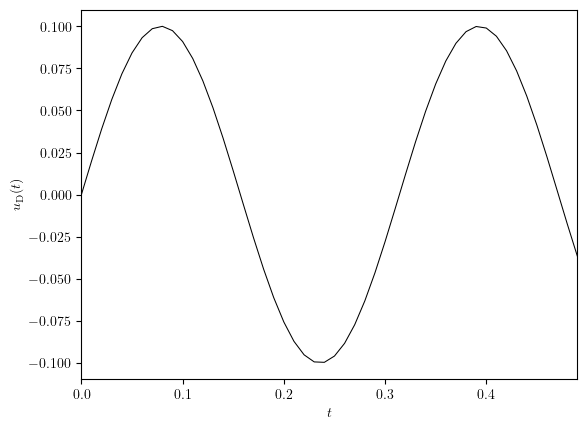

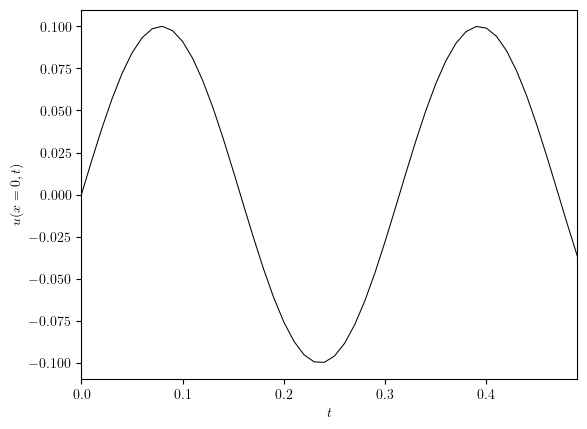

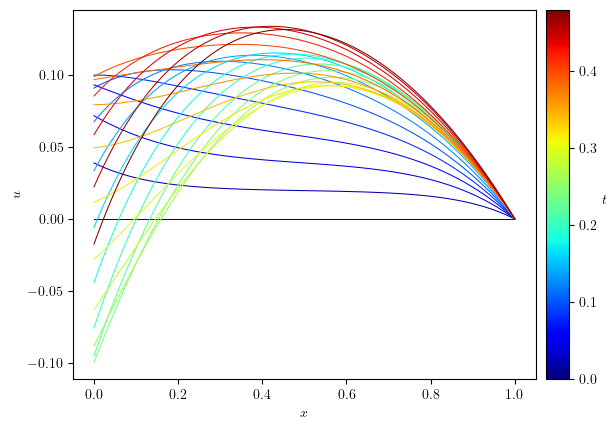

In [8]:
uD = simulation['uD']
fig, ax = plot_line((uD.time_series, uD.value_series), x_label='$t$', y_label='$u_{\mathrm{D}}(t)$')

u = simulation['u']
uD_num = [dofs[0] for dofs in u.dofs_series]
fig, ax = plot_line((uD.time_series, uD_num), x_label='$t$', y_label='$u(x=0, t)$')

slc = slice(0, None, 2)
legend_labels=(min(u.time_series[slc]), max(u.time_series[slc]))
plot_line(u.series[slc], legend_labels, '$t$', cyc='jet', x_label='$x$', y_label='$u$')

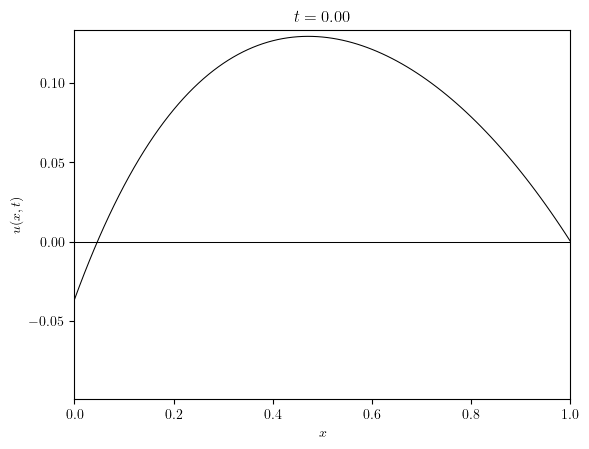

: 

In [ ]:
u_min = np.min([np.min(dofs) for dofs in u.dofs_series])
u_max = np.max([np.max(dofs) for dofs in u.dofs_series])

title_series = [f'$t={t:.2f}$' for t in u.time_series]
anim = create_animation(
    plot_line,
    y_lims=(u_min, u_max),
    x_label='$x$', 
    y_label='$u(x,t)$'
)(u.series, title=title_series)
write(anim, 'N08_time_dependent_dirichlet', './figures')

## Time-dependent Neumann boundary condition

$$\Omega = [0, L_x]$$

$$u_{\text{N}}(x=0, t)=\epsilon\sin(\omega t)$$

$$u_{\text{D}}(x=L_x)=0$$

In [ ]:
Lx = 1.0
Nx = 100
dt = 0.01
eps = 0.1
omega = 20
simulation = time_dependent_bcs_simulation(Lx, Nx, dt, eps, omega, 'neumann', BE, BE)
n_stop = 50
run(simulation, n_stop)

u = simulation['u']

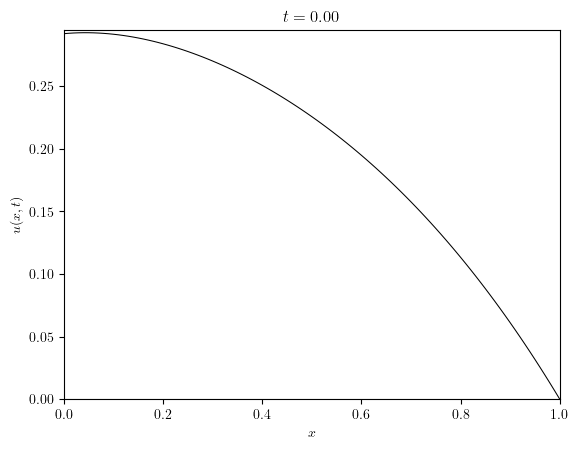

In [ ]:
u_min = np.min([np.min(dofs) for dofs in u.dofs_series])
u_max = np.max([np.max(dofs) for dofs in u.dofs_series])

title_series = [f'$t={t:.2f}$' for t in u.time_series]
anim = create_animation(
    plot_line,
    y_lims=(u_min, u_max),
    x_label='$x$', 
    y_label='$u(x,t)$'
)(u.series, title=title_series)
write(anim, 'N08_time_dependent_neumann', './figures')